In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from scikeras.wrappers import KerasClassifier
import time
import matplotlib.pyplot as plt

2024-06-21 13:05:21.630510: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 13:05:21.680881: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 13:05:21.847656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 13:05:22.646909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
seed = 1234
np.random.seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

In [3]:
def rgb_to_gray(rgb_images):
    gray_images = np.dot(rgb_images[...,: 3], [0.299, 0.587, 0.114])
    return gray_images

In [4]:
def get_dataset(directory):
    raw_npz = np.load(directory)
    X = raw_npz['images']
    y = raw_npz['labels']
    gray_images = rgb_to_gray(X)
    gray_images /= 255.0
    return gray_images, y

In [5]:
rf_hyp = {
    'n_estimators': 10,
    'criterion': 'log_loss',
    'max_depth': 5,
    'n_jobs': -1,
    'random_state': seed,
}

xgb_hyp = {
    'n_estimators': 10,
    'max_depth': 5,
    'random_state': seed,
}

svm_hyp = {
    'random_state': seed,
}

In [6]:
datasets = [
	('Dataset/car_bike_raw.npz', 'Car Bike Dataset'),
	('Dataset/cifar10_2_500.npz', 'CIFAR10 Dataset'),
	('Dataset/pizza_raw_32.npz', 'Pizza Dataset'),
	('Dataset/corals.npz', 'Corals Dataset'),
	('Dataset/eggs.npz', 'Eggs Dataset'),
	('Dataset/xray.npz', 'Xray Dataset'),
	('Dataset/covid.npz', 'Covid19 Dataset'),
]

In [7]:
class RK:
    def __init__(self, model, rf_hyp, svm_hyp):
        self.model = Model(inputs=model.input, outputs=x)
        self.rf_hyp = rf_hyp
        self.svm = SVC(**svm_hyp)

    def fit(self, X_train, y_train):
        num_images = X_train.shape[0]
        feature_maps = self.model.predict(X_train, verbose=0)

        num_filters = feature_maps.shape[-1]
        rf_predictions = []
        self.trained_rf = []
        for i in range(num_filters):
            features = feature_maps[:, :, :, i].reshape(num_images, -1)
            rf = RandomForestClassifier(**self.rf_hyp)
            rf.fit(features, y_train)
            self.trained_rf.append(rf)
            rf_predictions.append(rf.predict(features))
        stacked_predictions = np.stack(rf_predictions, axis=1)
        self.svm.fit(stacked_predictions, y_train)
        return self.svm.predict(stacked_predictions)
    
    def predict(self, X):
        num_images = X.shape[0]
        feature_maps = self.model.predict(X, verbose=0)

        num_filters = feature_maps.shape[-1]
        rf_predictions = []
        for i in range(num_filters):
            features = feature_maps[:, :, :, i].reshape(num_images, -1)
            rf_predictions.append(self.trained_rf[i].predict(features))
        stacked_predictions = np.stack(rf_predictions, axis=1)
        return self.svm.predict(stacked_predictions)

In [8]:
input_layer = tf.keras.Input(shape=(32, 32, 1))
conv_layer = layers.Conv2D(100, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(conv_layer)
model = Model(inputs=input_layer, outputs=x)
model.trainable = False

In [9]:
def cv(directory):
    X, y = get_dataset(directory)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    train_accs = []
    test_accs = []

    train_prec = []
    test_prec = []

    train_recall = []
    test_recall = []

    train_times = []
    test_times = []

    for i, (train_indices, test_indices) in enumerate(kf.split(X, y)):
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
        
        # Start of training time
        start_train_time = time.time()
        clf = RK(model, rf_hyp, svm_hyp)
        pred_train = clf.fit(X_train, y_train)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        train_times.append(train_time)
        # End of training, beginning of evaluation/test time
        
        start_test_time = time.time()
        pred_test = clf.predict(X_test)
        end_test_time = time.time()
        test_time = end_test_time - start_test_time
        # End of test time
        test_times.append(test_time)

        train_accs.append(accuracy_score(y_train, pred_train))
        test_accs.append(accuracy_score(y_test, pred_test))

        train_prec.append(precision_score(y_train, pred_train))
        test_prec.append(precision_score(y_test, pred_test))

        train_recall.append(recall_score(y_train, pred_train))
        test_recall.append(recall_score(y_test, pred_test))

    print("Train Accuracies: " + str(train_accs))
    print("Test Accuracies: " + str(test_accs))
    print("Train Precisions: " + str(train_prec))
    print("Test Precisions: " + str(test_prec))
    print("Train Recalls: " + str(train_recall))
    print("Test Recalls: " + str(test_recall))
    print("Train Times: " + str(train_times))
    print("Test Times: " + str(test_times))
    
    return train_accs, test_accs, train_prec, test_prec, train_recall, test_recall, train_times, test_times

In [10]:
for dataset, _ in datasets:
    print(dataset)
    cv(dataset)

Dataset/car_bike_raw.npz
Train Accuracies: [0.9671875, 0.96625, 0.97125, 0.96875, 0.9684375]
Test Accuracies: [0.86875, 0.88625, 0.84, 0.85375, 0.85625]
Train Precisions: [0.9716088328075709, 0.9715549936788875, 0.9748110831234257, 0.9740834386852086, 0.9734680985470625]
Test Precisions: [0.8753180661577609, 0.87409200968523, 0.8451776649746193, 0.8528678304239401, 0.8589420654911839]
Train Recalls: [0.9625, 0.960625, 0.9675, 0.963125, 0.963125]
Test Recalls: [0.86, 0.9025, 0.8325, 0.855, 0.8525]
Train Times: [5.090606927871704, 4.888696670532227, 4.815945625305176, 4.760646104812622, 4.942027807235718]
Test Times: [0.5864439010620117, 0.5208282470703125, 0.5732789039611816, 0.5648331642150879, 0.5623776912689209]
Dataset/cifar10_2_500.npz
Train Accuracies: [0.9925, 0.9925, 0.99375, 0.99, 0.9925]
Test Accuracies: [0.865, 0.825, 0.83, 0.875, 0.885]
Train Precisions: [1.0, 0.9974747474747475, 1.0, 1.0, 0.9949748743718593]
Test Precisions: [0.8543689320388349, 0.7777777777777778, 0.784482

In [47]:
class RKMod:
    def __init__(self, model, rf_hyp, svm_hyp):
        self.model = Model(inputs=model.input, outputs=x)
        self.rf_hyp = rf_hyp
        self.svm = SVC(**svm_hyp)

    def fit(self, X_train, y_train):
        num_images = X_train.shape[0]
        feature_maps = self.model.predict(X_train, verbose=0)

        num_filters = feature_maps.shape[-1]
        rf_predictions = []
        self.trained_rf = []
        self.train_accs = []
        for i in range(num_filters):
            features = feature_maps[:, :, :, i].reshape(num_images, -1)
            rf = RandomForestClassifier(**self.rf_hyp)
            rf.fit(features, y_train)
            self.trained_rf.append(rf)
            pred = rf.predict(features)
            rf_predictions.append(pred)
            self.train_accs.append(accuracy_score(y_train, pred))
        stacked_predictions = np.stack(rf_predictions, axis=1)
        self.svm.fit(stacked_predictions, y_train)
        return self.svm.predict(stacked_predictions)
    
    def predict(self, X, y):
        num_images = X.shape[0]
        feature_maps = self.model.predict(X, verbose=0)

        self.test_accs = []
        num_filters = feature_maps.shape[-1]
        rf_predictions = []
        for i in range(num_filters):
            features = feature_maps[:, :, :, i].reshape(num_images, -1)
            rf_pred = self.trained_rf[i].predict(features)
            rf_predictions.append(rf_pred)
            self.test_accs.append(accuracy_score(y, rf_pred))
        stacked_predictions = np.stack(rf_predictions, axis=1)
        return self.svm.predict(stacked_predictions)

    def plot_hists(self):
        fig, axs = plt.subplots(1, 2, figsize=(10, 7))
        axs[0].hist(self.train_accs, bins=100, color='blue', edgecolor='black', alpha=0.7)
        axs[0].set_title('Histogram of Train Accuracies')
        axs[0].set_xlabel('Accuracy')
        axs[0].set_ylabel('Frequency')
        
        axs[1].hist(self.test_accs, bins=100, color='green', edgecolor='black', alpha=0.7)
        axs[1].set_title('Histogram of Test Accuracies')
        axs[1].set_xlabel('Accuracy')
        axs[1].set_ylabel('Frequency')
        plt.show()
        print('Training Accuracies: ', self.train_accs)
        print('Test Accuracies: ', self.test_accs)
        return self.train_accs, self.test_accs

In [48]:
input_layer = tf.keras.Input(shape=(32, 32, 1))
conv_layer = layers.Conv2D(100, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(conv_layer)
model = Model(inputs=input_layer, outputs=x)
model.trainable = False

In [49]:
def indiv_acc(directory):
    X, y = get_dataset(directory)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    clf = RKMod(model, rf_hyp, svm_hyp)
    clf.fit(X_train, y_train)
    clf.predict(X_test, y_test)
    print(f'Dataset: {directory}')
    train_accs, test_accs = clf.plot_hists()
    return train_accs, test_accs

Dataset: Dataset/car_bike_raw.npz


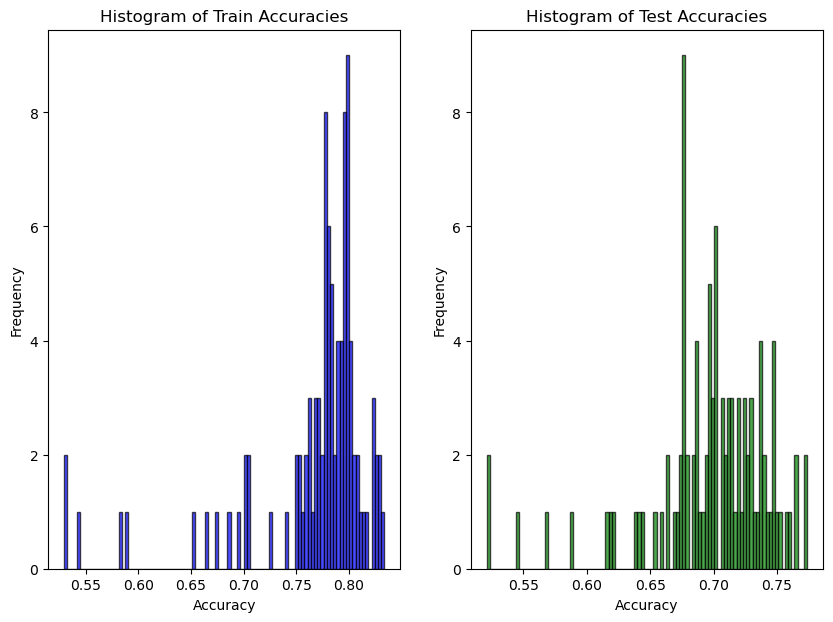

Training Accuracies:  [0.7771875, 0.8175, 0.783125, 0.7796875, 0.798125, 0.7990625, 0.7815625, 0.77625, 0.754375, 0.8278125, 0.7584375, 0.795, 0.8271875, 0.7834375, 0.7696875, 0.7953125, 0.7884375, 0.7996875, 0.7015625, 0.53, 0.8290625, 0.7890625, 0.7825, 0.7946875, 0.79875, 0.8015625, 0.74875, 0.685, 0.7715625, 0.7896875, 0.79125, 0.83375, 0.756875, 0.8228125, 0.7775, 0.825625, 0.788125, 0.780625, 0.7834375, 0.781875, 0.7915625, 0.7721875, 0.7959375, 0.765625, 0.80875, 0.775625, 0.791875, 0.8, 0.54375, 0.7525, 0.7628125, 0.788125, 0.8009375, 0.72625, 0.8071875, 0.653125, 0.803125, 0.7590625, 0.813125, 0.7734375, 0.7403125, 0.781875, 0.804375, 0.79875, 0.6946875, 0.78125, 0.798125, 0.7034375, 0.665625, 0.761875, 0.8040625, 0.5815625, 0.79375, 0.5296875, 0.77125, 0.76375, 0.77875, 0.784375, 0.77625, 0.7690625, 0.803125, 0.5890625, 0.6753125, 0.705625, 0.8228125, 0.7959375, 0.8228125, 0.7778125, 0.76875, 0.796875, 0.79625, 0.701875, 0.77875, 0.7975, 0.7765625, 0.7953125, 0.749375, 0.8096

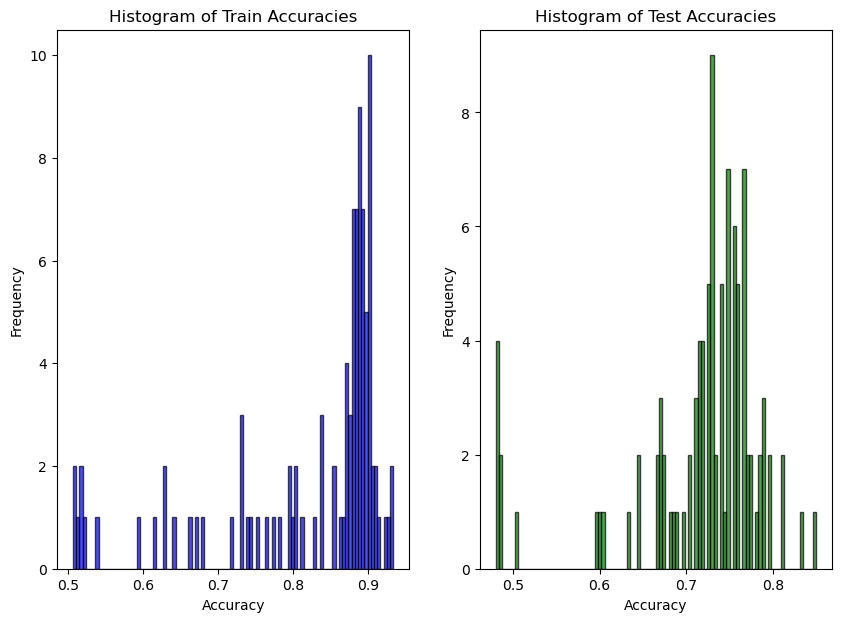

Training Accuracies:  [0.89, 0.9325, 0.73125, 0.87125, 0.88375, 0.85375, 0.79375, 0.8925, 0.73, 0.885, 0.87875, 0.8375, 0.90125, 0.89375, 0.88, 0.9075, 0.87, 0.9, 0.61625, 0.5075, 0.90125, 0.88375, 0.865, 0.75375, 0.855, 0.9, 0.81125, 0.6775, 0.8725, 0.90125, 0.87375, 0.915, 0.8875, 0.79875, 0.89125, 0.895, 0.9075, 0.9, 0.89625, 0.89, 0.90125, 0.88625, 0.9, 0.8375, 0.9, 0.8925, 0.88125, 0.88125, 0.5125, 0.73875, 0.7175, 0.88125, 0.89, 0.745, 0.80375, 0.59375, 0.88125, 0.89625, 0.93375, 0.8025, 0.73, 0.91, 0.88125, 0.88875, 0.63, 0.88875, 0.875, 0.66875, 0.52125, 0.875, 0.9225, 0.50625, 0.885, 0.515, 0.83875, 0.76625, 0.8975, 0.89375, 0.885, 0.79625, 0.89125, 0.5175, 0.64125, 0.53625, 0.83, 0.9025, 0.9275, 0.775, 0.8675, 0.88875, 0.88875, 0.62625, 0.89625, 0.89, 0.91125, 0.78375, 0.66125, 0.8975, 0.8775, 0.88375]
Test Accuracies:  [0.73, 0.81, 0.69, 0.67, 0.755, 0.785, 0.73, 0.75, 0.71, 0.81, 0.75, 0.78, 0.72, 0.725, 0.705, 0.755, 0.685, 0.715, 0.6, 0.48, 0.79, 0.785, 0.765, 0.665, 0.75

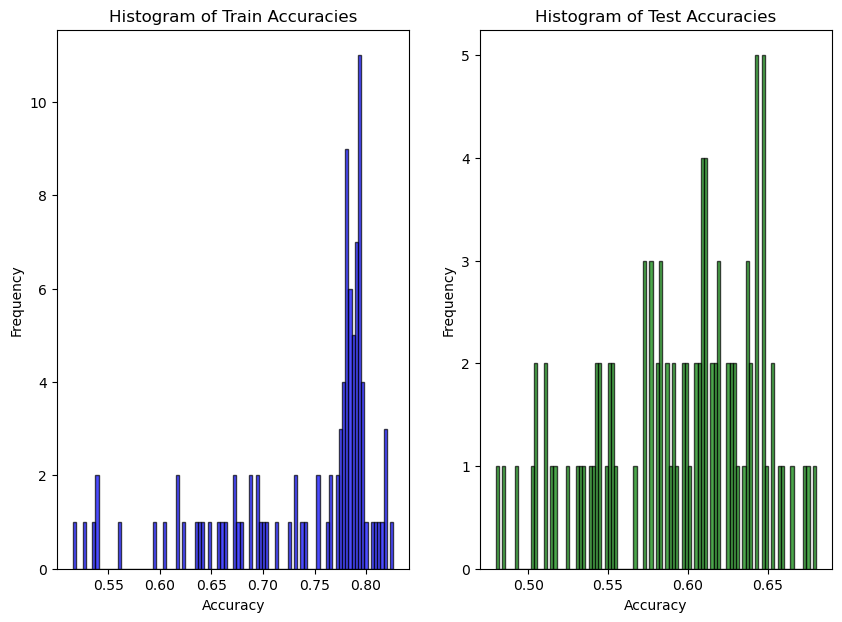

Training Accuracies:  [0.7729007633587787, 0.8110687022900763, 0.69529262086514, 0.7760814249363868, 0.7977099236641222, 0.7531806615776081, 0.7016539440203562, 0.7818066157760815, 0.6870229007633588, 0.7919847328244275, 0.7767175572519084, 0.767175572519084, 0.8263358778625954, 0.7862595419847328, 0.7849872773536896, 0.7818066157760815, 0.8104325699745547, 0.7926208651399491, 0.6049618320610687, 0.5159033078880407, 0.7938931297709924, 0.7881679389312977, 0.7900763358778626, 0.6870229007633588, 0.7321882951653944, 0.7919847328244275, 0.678117048346056, 0.6393129770992366, 0.7837150127226463, 0.7633587786259542, 0.7824427480916031, 0.8072519083969466, 0.7951653944020356, 0.7525445292620865, 0.7824427480916031, 0.7932569974554707, 0.7983460559796438, 0.7760814249363868, 0.7926208651399491, 0.7868956743002544, 0.7652671755725191, 0.7811704834605598, 0.7391857506361323, 0.6946564885496184, 0.8148854961832062, 0.7970737913486005, 0.7907124681933843, 0.7856234096692112, 0.5388040712468194, 0

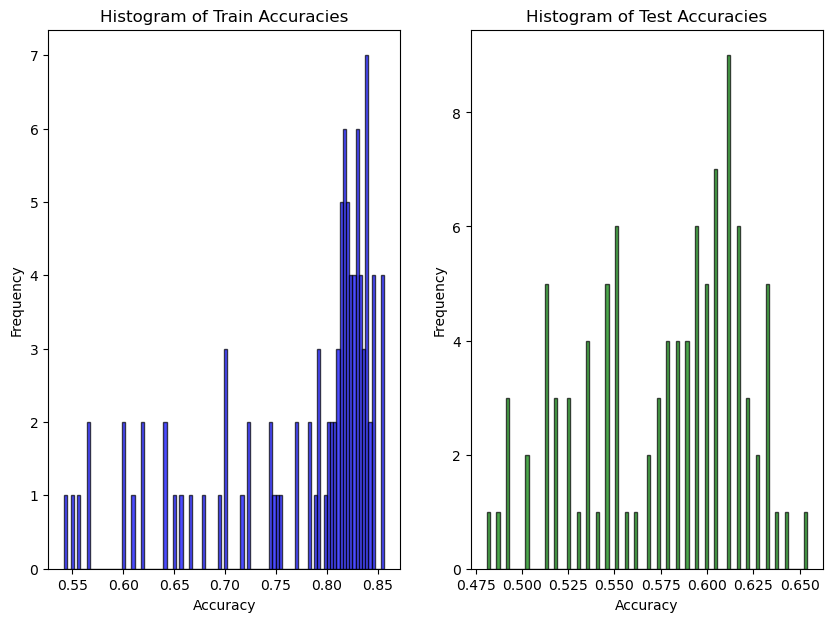

Training Accuracies:  [0.8306233062330624, 0.8441734417344173, 0.7466124661246613, 0.8536585365853658, 0.8279132791327913, 0.7913279132791328, 0.7452574525745257, 0.8143631436314364, 0.7710027100271003, 0.8008130081300813, 0.8387533875338753, 0.7994579945799458, 0.8292682926829268, 0.8292682926829268, 0.8130081300813008, 0.8238482384823849, 0.8306233062330624, 0.8441734417344173, 0.6395663956639567, 0.5420054200542005, 0.8401084010840109, 0.8455284552845529, 0.8428184281842819, 0.7005420054200542, 0.7696476964769647, 0.7886178861788617, 0.6991869918699187, 0.6653116531165312, 0.8265582655826558, 0.8211382113821138, 0.8224932249322493, 0.8387533875338753, 0.8333333333333334, 0.8387533875338753, 0.8102981029810298, 0.8455284552845529, 0.8184281842818428, 0.8306233062330624, 0.8333333333333334, 0.8184281842818428, 0.8224932249322493, 0.8157181571815718, 0.8252032520325203, 0.7222222222222222, 0.8387533875338753, 0.8116531165311653, 0.8197831978319783, 0.8211382113821138, 0.555555555555555

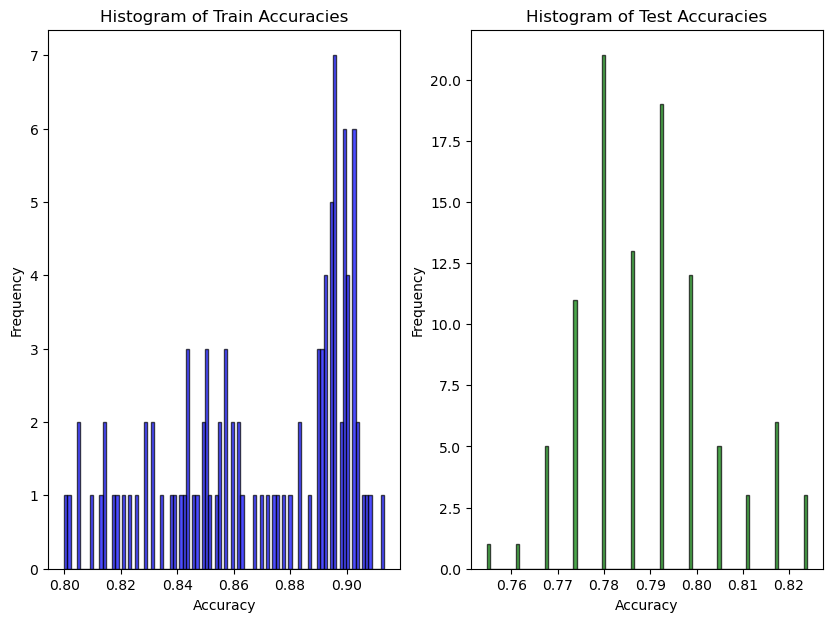

Training Accuracies:  [0.905511811023622, 0.8566929133858268, 0.8440944881889764, 0.8960629921259843, 0.8866141732283465, 0.8614173228346457, 0.84251968503937, 0.9023622047244094, 0.8440944881889764, 0.862992125984252, 0.9023622047244094, 0.8503937007874016, 0.889763779527559, 0.9007874015748032, 0.9007874015748032, 0.8944881889763779, 0.8834645669291339, 0.8803149606299212, 0.8125984251968504, 0.8015748031496063, 0.8614173228346457, 0.9086614173228347, 0.8960629921259843, 0.8488188976377953, 0.8566929133858268, 0.8992125984251969, 0.8283464566929134, 0.8251968503937008, 0.8960629921259843, 0.8960629921259843, 0.889763779527559, 0.8755905511811024, 0.8944881889763779, 0.8566929133858268, 0.889763779527559, 0.8503937007874016, 0.8929133858267716, 0.8992125984251969, 0.8834645669291339, 0.9070866141732283, 0.9007874015748032, 0.8913385826771654, 0.8488188976377953, 0.8440944881889764, 0.8740157480314961, 0.9133858267716536, 0.9023622047244094, 0.9039370078740158, 0.8, 0.8377952755905512,

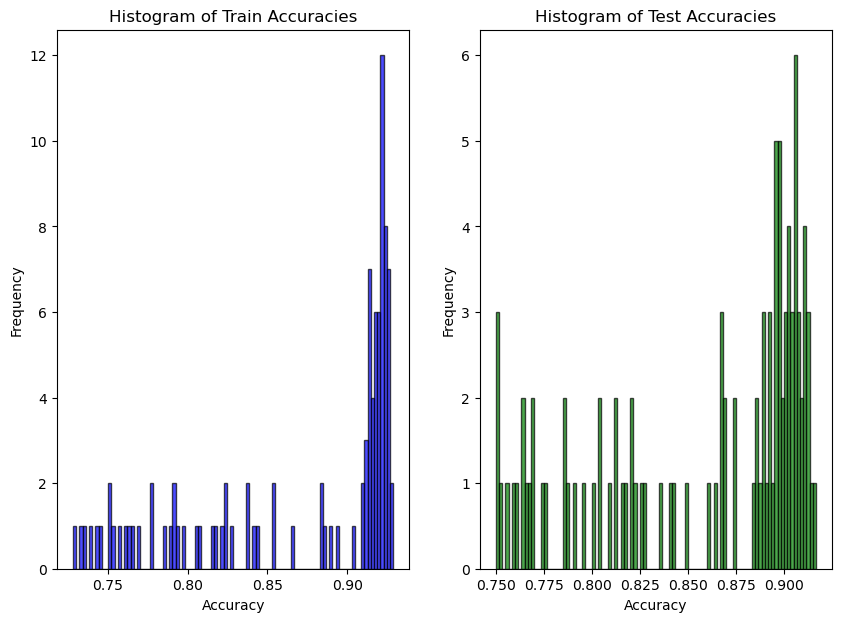

Training Accuracies:  [0.9284799316823228, 0.9154568744662681, 0.7907771135781383, 0.9148163962425278, 0.9233561058923997, 0.8531169940222032, 0.8238684884713919, 0.9237830913748932, 0.7888556789069172, 0.8896242527754057, 0.9210076857386849, 0.8377455166524338, 0.9263450042698548, 0.9180187873612298, 0.9146029035012809, 0.921861656703672, 0.9212211784799317, 0.9122544833475662, 0.7542698548249359, 0.7339880444064901, 0.8838599487617421, 0.9259180187873612, 0.9171648163962425, 0.7924850555081128, 0.8663535439795047, 0.9205807002561913, 0.8146883005977796, 0.7660119555935099, 0.9152433817250214, 0.9186592655849701, 0.9120409906063194, 0.9261315115286081, 0.9146029035012809, 0.841801878736123, 0.9139624252775406, 0.8845004269854825, 0.9289069171648164, 0.9137489325362937, 0.9088385994876175, 0.9160973526900086, 0.921861656703672, 0.9261315115286081, 0.8851409052092228, 0.8366780529461998, 0.9210076857386849, 0.9225021349274125, 0.9265584970111016, 0.9254910333048676, 0.7401793339026473, 

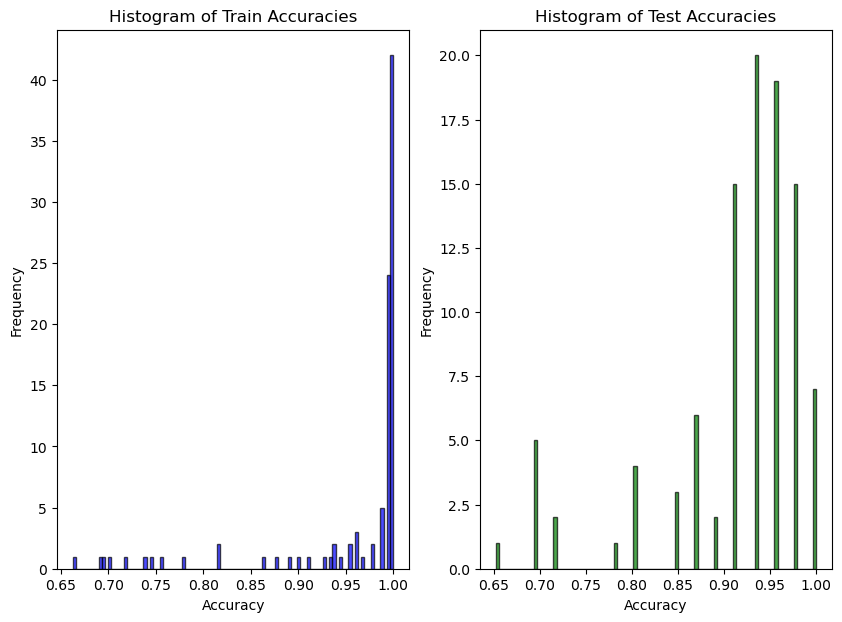

Training Accuracies:  [1.0, 1.0, 0.9281767955801105, 1.0, 1.0, 0.988950276243094, 0.9392265193370166, 0.994475138121547, 0.9613259668508287, 0.994475138121547, 0.994475138121547, 0.994475138121547, 1.0, 1.0, 0.994475138121547, 0.994475138121547, 0.994475138121547, 0.994475138121547, 0.8895027624309392, 0.6629834254143646, 1.0, 1.0, 1.0, 0.9558011049723757, 0.988950276243094, 1.0, 0.9005524861878453, 0.861878453038674, 0.994475138121547, 1.0, 0.994475138121547, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.988950276243094, 0.9447513812154696, 1.0, 1.0, 1.0, 1.0, 0.7016574585635359, 0.9558011049723757, 0.9337016574585635, 1.0, 0.994475138121547, 0.9392265193370166, 0.9779005524861878, 0.8176795580110497, 1.0, 1.0, 0.994475138121547, 0.988950276243094, 0.9613259668508287, 0.994475138121547, 0.994475138121547, 1.0, 0.9116022099447514, 0.994475138121547, 0.994475138121547, 0.7569060773480663, 0.7403314917127072, 0.994475138121547, 0.994475138121547, 0.6906077348066298, 1.0, 0.696

In [50]:
train_accuracies = {}
test_accuracies = {}

for dataset, name in datasets:
    train, test = indiv_acc(dataset)
    train_accuracies[name] = train
    test_accuracies[name] = test

print(train_accuracies)
print(test_accuracies)

In [51]:
import pandas as pd

In [52]:
data = []

for dataset, name in datasets:
    for train_acc, test_acc in zip(train_accuracies[name], test_accuracies[name]):
        data.append([name, train_acc, test_acc])

df = pd.DataFrame(data, columns=['Dataset', 'Train Accuracy', 'Test Accuracy'])

print(df)

              Dataset  Train Accuracy  Test Accuracy
0    Car Bike Dataset        0.777188       0.696250
1    Car Bike Dataset        0.817500       0.718750
2    Car Bike Dataset        0.783125       0.735000
3    Car Bike Dataset        0.779687       0.696250
4    Car Bike Dataset        0.798125       0.746250
..                ...             ...            ...
695   Covid19 Dataset        0.966851       0.934783
696   Covid19 Dataset        0.878453       0.804348
697   Covid19 Dataset        1.000000       0.934783
698   Covid19 Dataset        0.994475       0.913043
699   Covid19 Dataset        1.000000       0.934783

[700 rows x 3 columns]


In [54]:
df.to_csv('individual_accuracies.csv', index=False)

In [15]:
class RKBestF:
    def __init__(self, model, rf_hyp, svm_hyp):
        self.model = Model(inputs=model.input, outputs=model.layers[-1].output)
        self.rf_hyp = rf_hyp
        self.svm = SVC(**svm_hyp)
        self.trained_rf = []
        self.filter_accuracies = []

    def fit(self, X_train, y_train, X_test, y_test):
        num_images = X_train.shape[0]
        feature_maps = self.model.predict(X_train, verbose=0)

        num_filters = feature_maps.shape[-1]
        rf_predictions = []

        for i in range(num_filters):
            features = feature_maps[:, :, :, i].reshape(num_images, -1)
            rf = RandomForestClassifier(**self.rf_hyp)
            rf.fit(features, y_train)
            self.trained_rf.append(rf)
            
            # Evaluate on test set
            test_features = self.model.predict(X_test, verbose=0)[:, :, :, i].reshape(X_test.shape[0], -1)
            predictions = rf.predict(test_features)
            accuracy = accuracy_score(y_test, predictions)
            self.filter_accuracies.append((i, accuracy))
            rf_predictions.append(rf.predict(features))

        # Stack predictions for SVM training
        stacked_predictions = np.stack(rf_predictions, axis=1)
        self.svm.fit(stacked_predictions, y_train)

        # Sort filters by test accuracy
        self.filter_accuracies.sort(key=lambda x: x[1], reverse=True)

        return self.svm.predict(stacked_predictions)

    def plot_best_filters(self, X, num_filters=10):
        feature_maps = self.model.predict(X, verbose=0)
        best_filters = [idx for idx, acc in self.filter_accuracies[:num_filters]]

        # Plot one image from the best filters
        plt.figure(figsize=(10, 10))
        for i, filter_idx in enumerate([0] + best_filters):
            plt.subplot(1, num_filters + 1, i + 1)
            if i == 0:
                plt.imshow(X[0], cmap='gray')
            else:
                plt.imshow(feature_maps[0, :, :, filter_idx], cmap='gray')
            plt.axis('off')
        plt.show()

In [16]:
input_layer = tf.keras.Input(shape=(32, 32, 1))
conv_layer = layers.Conv2D(100, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(conv_layer)
model = Model(inputs=input_layer, outputs=x)
model.trainable = False

def convolved_images(directory):
    X, y = get_dataset(directory)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    clf = RKBestF(model, rf_hyp, svm_hyp)
    clf.fit(X_train, y_train, X_test, y_test)
    clf.plot_best_filters(X_test)

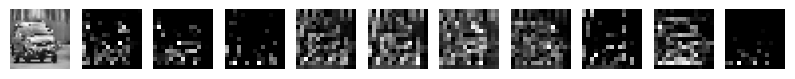

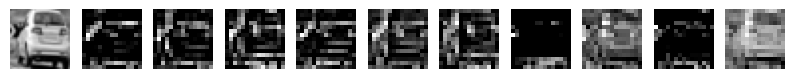

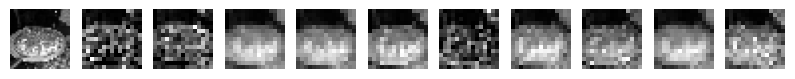

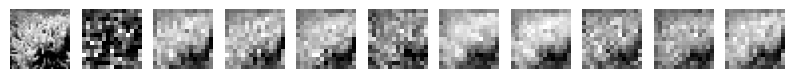

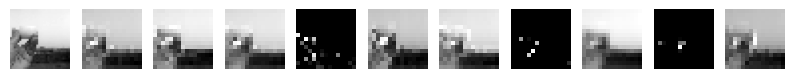

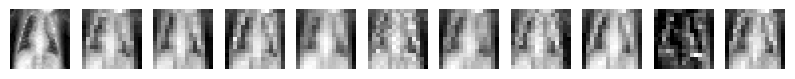

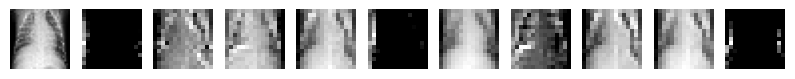

In [17]:
for dataset, _ in datasets:
    convolved_images(dataset)

2024-06-21 03:58:35.700981: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1296000000 exceeds 10% of free system memory.
2024-06-21 03:59:00.785706: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1440000000 exceeds 10% of free system memory.


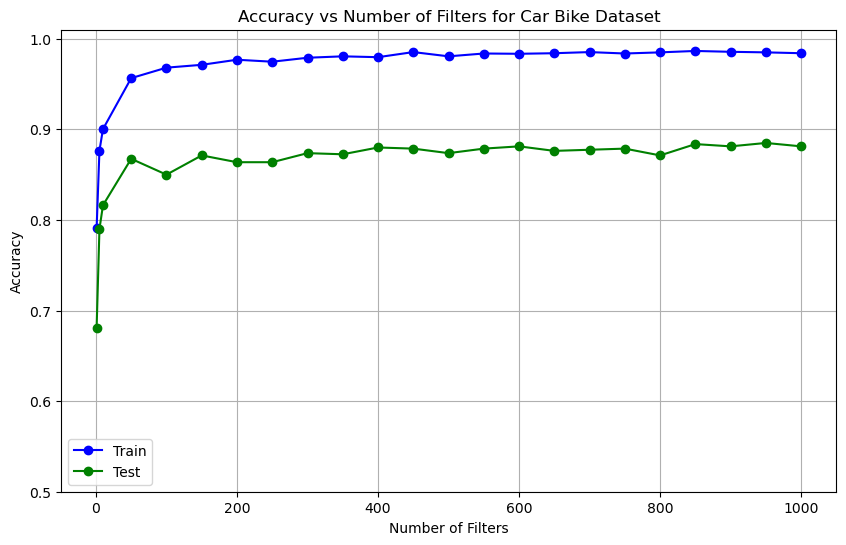

Car Bike Dataset
[0.79125, 0.8765625, 0.9003125, 0.9565625, 0.968125, 0.97125, 0.976875, 0.9746875, 0.9790625, 0.980625, 0.9796875, 0.9853125, 0.980625, 0.98375, 0.9834375, 0.9840625, 0.9853125, 0.98375, 0.985, 0.9865625, 0.985625, 0.985, 0.9840625]
[0.68125, 0.79, 0.81625, 0.8675, 0.85, 0.87125, 0.86375, 0.86375, 0.87375, 0.8725, 0.88, 0.87875, 0.87375, 0.87875, 0.88125, 0.87625, 0.8775, 0.87875, 0.87125, 0.88375, 0.88125, 0.885, 0.88125]


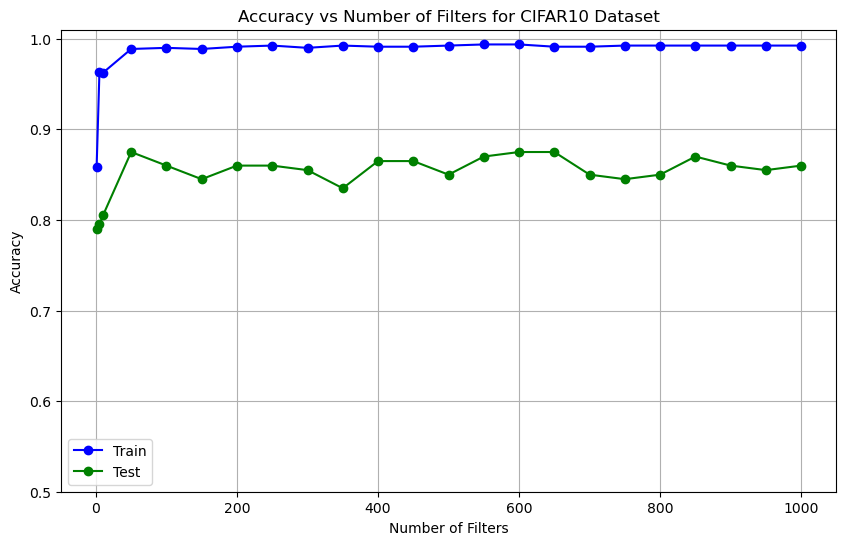

CIFAR10 Dataset
[0.85875, 0.96375, 0.9625, 0.98875, 0.99, 0.98875, 0.99125, 0.9925, 0.99, 0.9925, 0.99125, 0.99125, 0.9925, 0.99375, 0.99375, 0.99125, 0.99125, 0.9925, 0.9925, 0.9925, 0.9925, 0.9925, 0.9925]
[0.79, 0.795, 0.805, 0.875, 0.86, 0.845, 0.86, 0.86, 0.855, 0.835, 0.865, 0.865, 0.85, 0.87, 0.875, 0.875, 0.85, 0.845, 0.85, 0.87, 0.86, 0.855, 0.86]


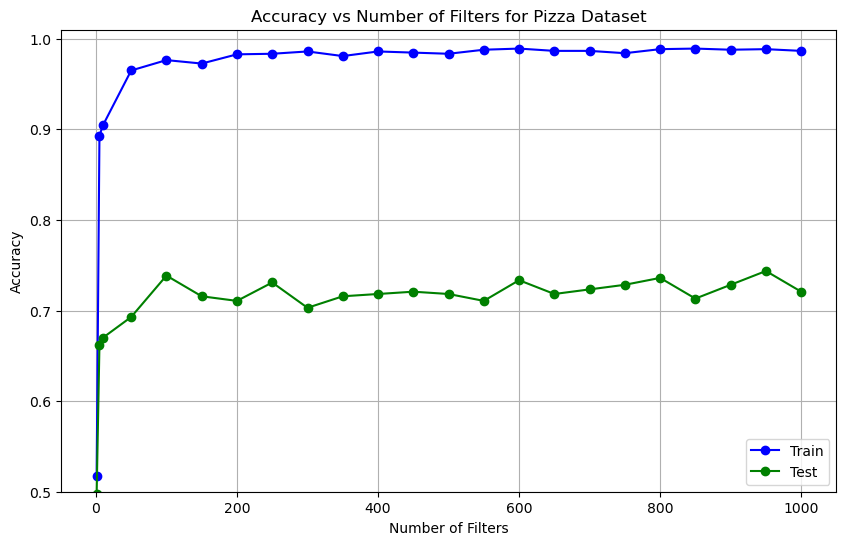

Pizza Dataset
[0.517175572519084, 0.8931297709923665, 0.9045801526717557, 0.9650127226463104, 0.9764631043256997, 0.97264631043257, 0.982824427480916, 0.9834605597964376, 0.9860050890585241, 0.9809160305343512, 0.9860050890585241, 0.9847328244274809, 0.9834605597964376, 0.9879134860050891, 0.9891857506361323, 0.9866412213740458, 0.9866412213740458, 0.9840966921119593, 0.9885496183206107, 0.9891857506361323, 0.9879134860050891, 0.9885496183206107, 0.9866412213740458]
[0.49746192893401014, 0.6624365482233503, 0.6700507614213198, 0.6928934010152284, 0.7385786802030457, 0.7157360406091371, 0.7106598984771574, 0.7309644670050761, 0.7030456852791879, 0.7157360406091371, 0.7182741116751269, 0.7208121827411168, 0.7182741116751269, 0.7106598984771574, 0.733502538071066, 0.7182741116751269, 0.7233502538071066, 0.7284263959390863, 0.7360406091370558, 0.7131979695431472, 0.7284263959390863, 0.7436548223350253, 0.7208121827411168]


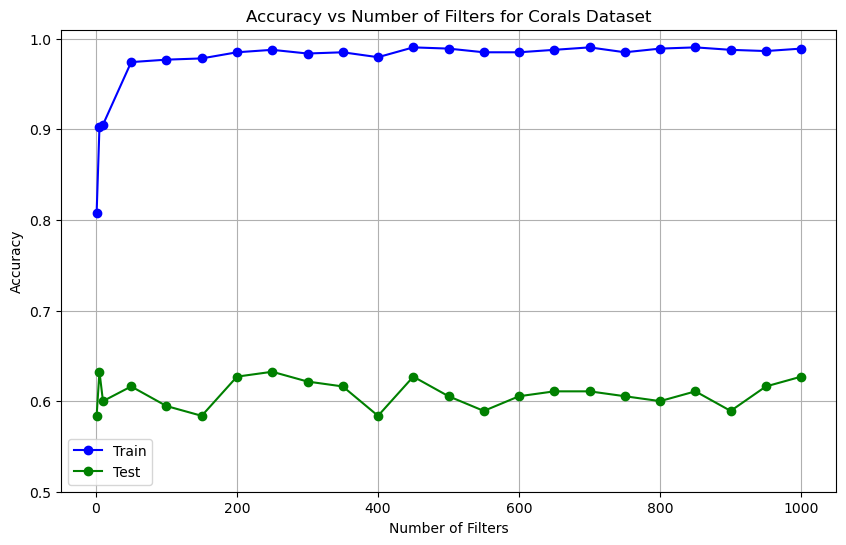

Corals Dataset
[0.8075880758807588, 0.9024390243902439, 0.9051490514905149, 0.9742547425474255, 0.9769647696476965, 0.978319783197832, 0.9850948509485095, 0.9878048780487805, 0.983739837398374, 0.9850948509485095, 0.9796747967479674, 0.9905149051490515, 0.989159891598916, 0.9850948509485095, 0.9850948509485095, 0.9878048780487805, 0.9905149051490515, 0.9850948509485095, 0.989159891598916, 0.9905149051490515, 0.9878048780487805, 0.986449864498645, 0.989159891598916]
[0.5837837837837838, 0.6324324324324324, 0.6, 0.6162162162162163, 0.5945945945945946, 0.5837837837837838, 0.6270270270270271, 0.6324324324324324, 0.6216216216216216, 0.6162162162162163, 0.5837837837837838, 0.6270270270270271, 0.6054054054054054, 0.5891891891891892, 0.6054054054054054, 0.6108108108108108, 0.6108108108108108, 0.6054054054054054, 0.6, 0.6108108108108108, 0.5891891891891892, 0.6162162162162163, 0.6270270270270271]


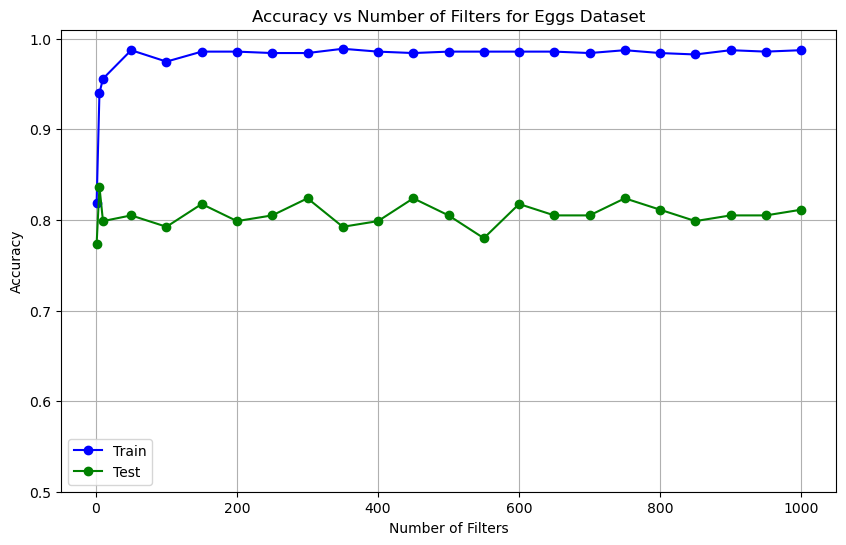

Eggs Dataset
[0.8188976377952756, 0.9401574803149606, 0.9559055118110236, 0.9874015748031496, 0.9748031496062992, 0.9858267716535433, 0.9858267716535433, 0.984251968503937, 0.984251968503937, 0.988976377952756, 0.9858267716535433, 0.984251968503937, 0.9858267716535433, 0.9858267716535433, 0.9858267716535433, 0.9858267716535433, 0.984251968503937, 0.9874015748031496, 0.984251968503937, 0.9826771653543307, 0.9874015748031496, 0.9858267716535433, 0.9874015748031496]
[0.7735849056603774, 0.8364779874213837, 0.7987421383647799, 0.8050314465408805, 0.7924528301886793, 0.8176100628930818, 0.7987421383647799, 0.8050314465408805, 0.8238993710691824, 0.7924528301886793, 0.7987421383647799, 0.8238993710691824, 0.8050314465408805, 0.779874213836478, 0.8176100628930818, 0.8050314465408805, 0.8050314465408805, 0.8238993710691824, 0.8113207547169812, 0.7987421383647799, 0.8050314465408805, 0.8050314465408805, 0.8113207547169812]


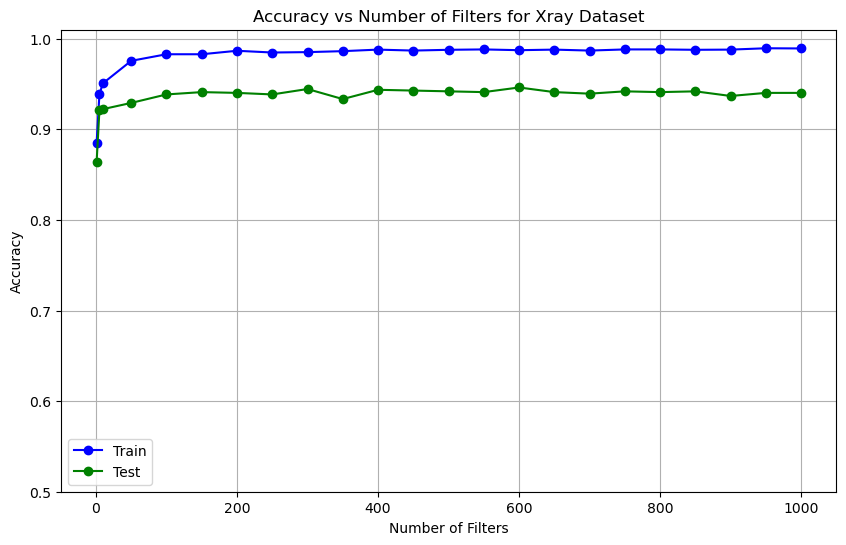

Xray Dataset
[0.8853543979504697, 0.9391545687446626, 0.9508966695132366, 0.9756618274978651, 0.9829205807002562, 0.9829205807002562, 0.9867634500426985, 0.9848420153714774, 0.985269000853971, 0.986336464560205, 0.9880444064901793, 0.9869769427839453, 0.9878309137489325, 0.9882578992314262, 0.987403928266439, 0.9880444064901793, 0.9869769427839453, 0.9882578992314262, 0.9882578992314262, 0.9878309137489325, 0.9880444064901793, 0.9895388556789069, 0.9893253629376602]
[0.8643344709897611, 0.9215017064846417, 0.9223549488054608, 0.9291808873720137, 0.9385665529010239, 0.9411262798634812, 0.9402730375426621, 0.9385665529010239, 0.9445392491467577, 0.9334470989761092, 0.9436860068259386, 0.9428327645051194, 0.9419795221843004, 0.9411262798634812, 0.9462457337883959, 0.9411262798634812, 0.939419795221843, 0.9419795221843004, 0.9411262798634812, 0.9419795221843004, 0.9368600682593856, 0.9402730375426621, 0.9402730375426621]


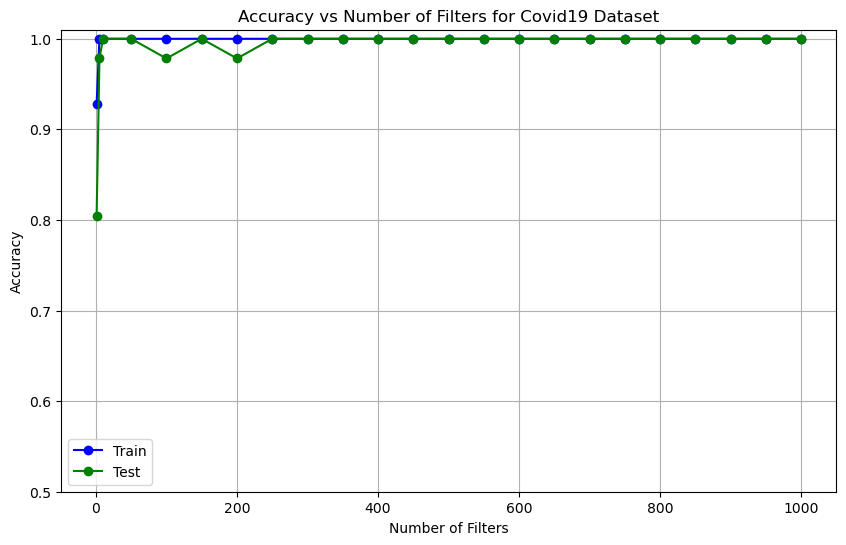

Covid19 Dataset
[0.9281767955801105, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.8043478260869565, 0.9782608695652174, 1.0, 1.0, 0.9782608695652174, 1.0, 0.9782608695652174, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [18]:
num_filters_range = [1, 5, 10] + list(range(50, 1001, 50))

for directory, dataset_name in datasets:
    train_accs = []
    test_accs = []
    for num_filters in num_filters_range:
        input_layer = tf.keras.Input(shape=(32, 32, 1))
        conv_layer = layers.Conv2D(num_filters, (3, 3), activation='relu')(input_layer)
        x = layers.MaxPooling2D((2, 2))(conv_layer)
        model = Model(inputs=input_layer, outputs=x)
        model.trainable = False
        X, y = get_dataset(directory)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        clf = RK(model, rf_hyp, svm_hyp)
        pred_train = clf.fit(X_train, y_train)
        pred_test = clf.predict(X_test)
        train_accs.append(accuracy_score(y_train, pred_train))
        test_accs.append(accuracy_score(y_test, pred_test))
        
    plt.figure(figsize=(10, 6))
    plt.title(f"Accuracy vs Number of Filters for {dataset_name}")
    plt.xlabel("Number of Filters")
    plt.ylabel("Accuracy")
    plt.ylim(0.5, 1.01)
    
    plt.plot(num_filters_range, train_accs, color='blue', marker='o', label='Train')
    plt.plot(num_filters_range, test_accs, color='green', marker='o', label='Test')
    
    plt.legend()
    plt.grid()
    plt.show()
    print(dataset_name)
    print(train_accs)
    print(test_accs)

In [19]:
def create_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2)  # Output layer with number of classes
    ])
    model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    return model

In [20]:
def nn_cv(directory):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    simpleCNN = KerasClassifier(model=create_model, epochs=20, batch_size=64, verbose=0)
    X, y = get_dataset(directory)
    results = cross_validate(simpleCNN, X, y, scoring=['accuracy', 'precision', 'recall'], cv=kf, return_train_score=True)
    print(directory)
    print(results['train_accuracy'])
    print(results['test_accuracy'])
    print(results['train_precision'])
    print(results['test_precision'])
    print(results['train_recall'])
    print(results['test_recall'])
    print(results['fit_time'])
    print(results['score_time'])

In [21]:
for dataset, _ in datasets:
    nn_cv(dataset)

/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Dataset/car_bike_raw.npz
[0.9859375 0.985625  0.9525    0.995     0.99375  ]
[0.9075  0.89375 0.85875 0.93125 0.925  ]
[0.97379647 1.         0.91466208 0.99315068 0.99436796]
[0.86877828 0.94117647 0.80338266 0.94573643 0.93147208]
[0.99875  0.97125  0.998125 0.996875 0.993125]
[0.96   0.84   0.95   0.915  0.9175]
[16.2252543  15.90550995 16.06107736 15.84112811 15.92095757]
[0.18455315 0.20165873 0.1629281  0.15912747 0.15987849]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Dataset/cifar10_2_500.npz
[0.925   0.95625 0.97875 0.9725  0.9675 ]
[0.84  0.815 0.905 0.885 0.865]
[0.98295455 0.91954023 0.97994987 0.9478673  0.99210526]
[0.93589744 0.76470588 0.89320388 0.81300813 0.91954023]
[0.865  1.     0.9775 1.     0.9425]
[0.73 0.91 0.92 1.   0.8 ]
[4.93678808 5.33655691 5.00551248 4.94988751 4.93874311]
[0.1225071  0.13724017 0.12198997 0.13487649 0.11790943]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Dataset/pizza_raw_32.npz
[0.94592875 0.89446917 0.91671964 0.93452003 0.94787031]
[0.7106599  0.72264631 0.74554707 0.7302799  0.74045802]
[0.92691839 0.92946058 0.9079602  0.99854015 0.96073298]
[0.70243902 0.73513514 0.73300971 0.82733813 0.7486911 ]
[0.96819338 0.85387548 0.92757306 0.87022901 0.93384224]
[0.73096447 0.69387755 0.77040816 0.58375635 0.72588832]
[8.48803306 8.80209589 8.83097291 9.03161383 8.56831908]
[0.13548446 0.13539171 0.13553309 0.15855312 0.13417745]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Dataset/corals.npz
[0.87804878 0.8197832  0.88211382 0.9120433  0.84979702]
[0.64324324 0.64324324 0.61081081 0.59782609 0.55978261]
[0.9027027  0.77537797 0.88295165 0.89104116 0.79657388]
[0.67032967 0.6302521  0.62135922 0.6036036  0.56451613]
[0.86082474 0.92525773 0.8943299  0.94845361 0.95876289]
[0.62886598 0.77319588 0.65979381 0.69072165 0.72164948]
[4.72703815 4.72339797 4.72603345 4.74904251 4.74900675]
[0.11755848 0.12122583 0.11693001 0.11753654 0.11715508]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Dataset/eggs.npz
[0.93385827 0.90393701 0.90866142 0.90393701 0.91823899]
[0.79245283 0.77987421 0.89308176 0.81132075 0.84810127]
[0.95490196 0.92870906 0.91620112 0.96058091 0.92509363]
[0.85496183 0.87603306 0.91666667 0.95327103 0.86956522]
[0.96245059 0.95256917 0.97425743 0.91683168 0.97628458]
[0.88888889 0.84126984 0.95275591 0.80314961 0.95238095]
[4.26611328 4.27414846 4.31265354 4.2966404  4.32432532]
[0.11615992 0.11866188 0.12067866 0.13058543 0.11906958]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Dataset/xray.npz
[0.99316823 0.95154749 0.97524013 0.96883671 0.97630736]
[0.95392491 0.94278395 0.941076   0.95900939 0.94790777]
[0.99648094 0.93941063 0.967176   0.96111581 0.96988636]
[0.97173145 0.93107221 0.93473451 0.95588235 0.94301676]
[0.99414862 0.99795202 1.         0.99766013 0.99853758]
[0.96491228 0.99532164 0.98830409 0.98946136 0.9882904 ]
[23.60481071 23.61860037 23.57850432 23.47308898 23.44797134]
[0.20075941 0.19926906 0.19300318 0.19478202 0.18959188]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Dataset/covid.npz
[0.99447514 1.         1.         0.98901099 1.        ]
[1.         1.         0.97777778 1.         1.        ]
[0.98630137 1.         1.         0.97297297 1.        ]
[1.         1.         0.94736842 1.         1.        ]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[2.12121582 2.05583405 2.13327837 2.12595439 2.11394954]
[0.09044552 0.63265491 0.07511687 0.07338786 0.07393932]


In [22]:
def rf_cv(directory):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    clf = RandomForestClassifier(n_jobs=-1, random_state=seed)
    X, y = get_dataset(directory)
    results = cross_validate(clf, X.reshape(X.shape[0], -1), y, scoring=['accuracy', 'precision', 'recall'], cv=kf, return_train_score=True)
    print(directory)
    print(results['train_accuracy'])
    print(results['test_accuracy'])
    print(results['train_precision'])
    print(results['test_precision'])
    print(results['train_recall'])
    print(results['test_recall'])
    print(results['fit_time'])
    print(results['score_time'])

In [23]:
for dataset, _ in datasets:
    rf_cv(dataset)

Dataset/car_bike_raw.npz
[1. 1. 1. 1. 1.]
[0.8125  0.8125  0.80875 0.83125 0.8225 ]
[1. 1. 1. 1. 1.]
[0.84530387 0.8342246  0.82077922 0.84415584 0.83247423]
[1. 1. 1. 1. 1.]
[0.765  0.78   0.79   0.8125 0.8075]
[2.43617225 0.9271493  0.95104194 0.95608234 0.96107745]
[0.02791882 0.02401447 0.0245707  0.02480221 0.02383471]
Dataset/cifar10_2_500.npz
[1. 1. 1. 1. 1.]
[0.805 0.78  0.83  0.825 0.855]
[1. 1. 1. 1. 1.]
[0.79047619 0.75       0.81730769 0.77310924 0.82568807]
[1. 1. 1. 1. 1.]
[0.83 0.84 0.85 0.92 0.9 ]
[0.27705264 0.2837534  0.27954125 0.27875447 0.27958035]
[0.02158999 0.02059102 0.01975822 0.01350927 0.02013874]
Dataset/pizza_raw_32.npz
[1. 1. 1. 1. 1.]
[0.63959391 0.66666667 0.66666667 0.6692112  0.63613232]
[1. 1. 1. 1. 1.]
[0.64705882 0.66666667 0.67567568 0.66834171 0.64673913]
[1. 1. 1. 1. 1.]
[0.6142132  0.66326531 0.6377551  0.6751269  0.60406091]
[0.51947689 0.53325438 0.54073477 0.55388212 0.51779628]
[0.02011204 0.02415109 0.02352762 0.02271676 0.02262759]
Datase

In [24]:
def svm_cv(directory):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    clf = SVC(random_state=seed)
    X, y = get_dataset(directory)
    results = cross_validate(clf, X.reshape(X.shape[0], -1), y, scoring=['accuracy', 'precision', 'recall'], cv=kf, return_train_score=True)
    print(directory)
    print(results['train_accuracy'])
    print(results['test_accuracy'])
    print(results['train_precision'])
    print(results['test_precision'])
    print(results['train_recall'])
    print(results['test_recall'])
    print(results['fit_time'])
    print(results['score_time'])

In [25]:
for dataset, _ in datasets:
    svm_cv(dataset)

Dataset/car_bike_raw.npz
[0.9215625 0.9209375 0.9240625 0.925     0.9203125]
[0.805   0.82375 0.8175  0.81875 0.82   ]
[0.91920447 0.91858297 0.91960421 0.92288557 0.91181874]
[0.81282051 0.82294264 0.82070707 0.82442748 0.80331754]
[0.924375 0.92375  0.929375 0.9275   0.930625]
[0.7925 0.825  0.8125 0.81   0.8475]
[2.43761086 2.36661196 2.3684957  2.39101982 2.39184141]
[0.85286331 0.84723663 0.86272478 0.92628312 0.85681868]
Dataset/cifar10_2_500.npz
[0.93125 0.93375 0.9375  0.935   0.9375 ]
[0.785 0.78  0.815 0.81  0.855]
[0.90973872 0.91211401 0.91273585 0.92028986 0.91666667]
[0.77142857 0.74137931 0.82474227 0.76271186 0.8317757 ]
[0.9575 0.96   0.9675 0.9525 0.9625]
[0.81 0.86 0.8  0.9  0.89]
[0.07662773 0.07558012 0.07862997 0.07465196 0.07583261]
[0.03789783 0.03848553 0.03801513 0.03828168 0.03956127]
Dataset/pizza_raw_32.npz
[0.89185751 0.89383344 0.89574062 0.90336936 0.89637635]
[0.65482234 0.68447837 0.69465649 0.69211196 0.63613232]
[0.93258427 0.9454023  0.943101   0.94

In [10]:
def embedding_rf(directory):
    X, y = get_dataset(directory)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    feature_extractor = tf.keras.Sequential([
        layers.Conv2D(100, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
    ])
    
    train_accs = []
    test_accs = []

    train_prec = []
    test_prec = []

    train_recall = []
    test_recall = []

    train_times = []
    test_times = []

    for i, (train_indices, test_indices) in enumerate(kf.split(X, y)):
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
        
        # Start of training time
        start_train_time = time.time()
        train_features = feature_extractor.predict(X_train, verbose=0)
        clf = RandomForestClassifier(n_jobs=-1, random_state=seed)
        clf.fit(train_features, y_train)
        pred_train = clf.predict(train_features)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        train_times.append(train_time)
        # End of training, beginning of evaluation/test time
        
        start_test_time = time.time()
        test_features = feature_extractor.predict(X_test, verbose=0)
        pred_test = clf.predict(test_features)
        end_test_time = time.time()
        test_time = end_test_time - start_test_time
        # End of test time
        test_times.append(test_time)

        train_accs.append(accuracy_score(y_train, pred_train))
        test_accs.append(accuracy_score(y_test, pred_test))

        train_prec.append(precision_score(y_train, pred_train))
        test_prec.append(precision_score(y_test, pred_test))

        train_recall.append(recall_score(y_train, pred_train))
        test_recall.append(recall_score(y_test, pred_test))

    print("Train Accuracies: " + str(train_accs))
    print("Test Accuracies: " + str(test_accs))
    print("Train Precisions: " + str(train_prec))
    print("Test Precisions: " + str(test_prec))
    print("Train Recalls: " + str(train_recall))
    print("Test Recalls: " + str(test_recall))
    print("Train Times: " + str(train_times))
    print("Test Times: " + str(test_times))
    
    return train_accs, test_accs, train_prec, test_prec, train_recall, test_recall, train_times, test_times

In [12]:
for dataset, _ in datasets:
    embedding_rf(dataset)

/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracies: [0.865, 0.865, 0.86875, 0.86625, 0.855]
Train Precisions: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Precisions: [0.8802083333333334, 0.8724489795918368, 0.8791773778920309, 0.8708860759493671, 0.8756613756613757]
Train Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Recalls: [0.845, 0.855, 0.855, 0.86, 0.8275]
Train Times: [3.4573922157287598, 3.388692855834961, 3.5236785411834717, 3.483844757080078, 3.5280256271362305]
Test Times: [0.17847800254821777, 0.17654156684875488, 0.17931032180786133, 0.1755208969116211, 0.17959213256835938]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracies: [0.86, 0.835, 0.83, 0.88, 0.89]
Train Precisions: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Precisions: [0.8529411764705882, 0.8130841121495327, 0.8055555555555556, 0.8333333333333334, 0.89]
Train Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Recalls: [0.87, 0.87, 0.87, 0.95, 0.89]
Train Times: [0.6568541526794434, 0.6264317035675049, 0.6284468173980713, 0.61240553855896, 0.6151890754699707]
Test Times: [0.08187627792358398, 0.07574319839477539, 0.07151293754577637, 0.0703120231628418, 0.11768150329589844]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracies: [0.6852791878172588, 0.712468193384224, 0.7404580152671756, 0.7022900763358778, 0.6972010178117048]
Train Precisions: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Precisions: [0.7134502923976608, 0.7243243243243244, 0.7526881720430108, 0.7352941176470589, 0.7119565217391305]
Train Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Recalls: [0.6192893401015228, 0.6836734693877551, 0.7142857142857143, 0.6345177664974619, 0.6649746192893401]
Train Times: [1.6295647621154785, 1.5476274490356445, 1.5681917667388916, 1.5224552154541016, 1.5269880294799805]
Test Times: [0.10511445999145508, 0.10437178611755371, 0.1135258674621582, 0.1019294261932373, 0.11449265480041504]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.9905149051490515, 0.9932249322493225, 0.9905149051490515, 0.9905277401894452, 0.9945872801082544]
Test Accuracies: [0.6648648648648648, 0.654054054054054, 0.6108108108108108, 0.6413043478260869, 0.7010869565217391]
Train Precisions: [0.9973890339425587, 0.9948320413436692, 0.9948051948051948, 0.9948051948051948, 0.9948453608247423]
Test Precisions: [0.6699029126213593, 0.6896551724137931, 0.6288659793814433, 0.6371681415929203, 0.71875]
Train Recalls: [0.9845360824742269, 0.9922680412371134, 0.9871134020618557, 0.9871134020618557, 0.9948453608247423]
Test Recalls: [0.711340206185567, 0.6185567010309279, 0.6288659793814433, 0.7422680412371134, 0.711340206185567]
Train Times: [0.7403395175933838, 0.7148072719573975, 0.7071521282196045, 0.7179877758026123, 0.6809794902801514]
Test Times: [0.0686488151550293, 0.07360434532165527, 0.06752729415893555, 0.06744551658630371, 0.06809782981872559]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.9984251968503937, 1.0, 0.9984251968503937, 0.9968503937007874, 0.9968553459119497]
Test Accuracies: [0.7924528301886793, 0.8364779874213837, 0.8427672955974843, 0.8050314465408805, 0.8417721518987342]
Train Precisions: [0.9980276134122288, 1.0, 0.9980237154150198, 0.9960552268244576, 0.9960629921259843]
Test Precisions: [0.8206896551724138, 0.852112676056338, 0.8445945945945946, 0.8243243243243243, 0.8344370860927153]
Train Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Recalls: [0.9444444444444444, 0.9603174603174603, 0.984251968503937, 0.9606299212598425, 1.0]
Train Times: [0.7076301574707031, 0.6439220905303955, 0.6678965091705322, 0.6847147941589355, 0.802793025970459]
Test Times: [0.06364774703979492, 0.0643928050994873, 0.09240102767944336, 0.05973410606384277, 0.06432914733886719]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracies: [0.9411262798634812, 0.9444918872758327, 0.946199829205807, 0.950469684030743, 0.9291204099060631]
Train Precisions: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Precisions: [0.9455782312925171, 0.945823927765237, 0.95, 0.957471264367816, 0.9365798414496036]
Train Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Recalls: [0.9754385964912281, 0.9801169590643275, 0.9777777777777777, 0.9754098360655737, 0.968384074941452]
Train Times: [7.227559328079224, 7.6937644481658936, 7.470077276229858, 7.37908148765564, 7.308592319488525]
Test Times: [0.2565598487854004, 0.24416279792785645, 0.24189138412475586, 0.2441098690032959, 0.24465179443359375]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracies: [0.9347826086956522, 0.9782608695652174, 0.9777777777777777, 1.0, 0.9777777777777777]
Train Precisions: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Precisions: [0.8571428571428571, 1.0, 0.9473684210526315, 1.0, 1.0]
Train Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Recalls: [1.0, 0.9444444444444444, 1.0, 1.0, 0.9444444444444444]
Train Times: [0.18876075744628906, 0.17578601837158203, 0.1707592010498047, 0.1605675220489502, 0.15979266166687012]
Test Times: [0.05251741409301758, 0.048935651779174805, 0.04549145698547363, 0.04616737365722656, 0.04664444923400879]


In [13]:
def embedding_svm(directory):
    X, y = get_dataset(directory)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    feature_extractor = tf.keras.Sequential([
        layers.Conv2D(100, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
    ])
    
    train_accs = []
    test_accs = []

    train_prec = []
    test_prec = []

    train_recall = []
    test_recall = []

    train_times = []
    test_times = []

    for i, (train_indices, test_indices) in enumerate(kf.split(X, y)):
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
        
        # Start of training time
        start_train_time = time.time()
        train_features = feature_extractor.predict(X_train, verbose=0)
        clf = SVC(random_state=seed)
        clf.fit(train_features, y_train)
        pred_train = clf.predict(train_features)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        train_times.append(train_time)
        # End of training, beginning of evaluation/test time
        
        start_test_time = time.time()
        test_features = feature_extractor.predict(X_test, verbose=0)
        pred_test = clf.predict(test_features)
        end_test_time = time.time()
        test_time = end_test_time - start_test_time
        # End of test time
        test_times.append(test_time)

        train_accs.append(accuracy_score(y_train, pred_train))
        test_accs.append(accuracy_score(y_test, pred_test))

        train_prec.append(precision_score(y_train, pred_train))
        test_prec.append(precision_score(y_test, pred_test))

        train_recall.append(recall_score(y_train, pred_train))
        test_recall.append(recall_score(y_test, pred_test))

    print("Train Accuracies: " + str(train_accs))
    print("Test Accuracies: " + str(test_accs))
    print("Train Precisions: " + str(train_prec))
    print("Test Precisions: " + str(test_prec))
    print("Train Recalls: " + str(train_recall))
    print("Test Recalls: " + str(test_recall))
    print("Train Times: " + str(train_times))
    print("Test Times: " + str(test_times))
    
    return train_accs, test_accs, train_prec, test_prec, train_recall, test_recall, train_times, test_times

In [14]:
for dataset, _ in datasets:
    embedding_svm(dataset)

/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.9184375, 0.9125, 0.9209375, 0.908125, 0.9153125]
Test Accuracies: [0.8725, 0.865, 0.87375, 0.885, 0.8725]
Train Precisions: [0.9294419499679282, 0.923620025673941, 0.9292543021032504, 0.9218346253229974, 0.9224411951684679]
Test Precisions: [0.882051282051282, 0.8802083333333334, 0.8863049095607235, 0.8948717948717949, 0.8706467661691543]
Train Recalls: [0.905625, 0.899375, 0.91125, 0.891875, 0.906875]
Test Recalls: [0.86, 0.845, 0.8575, 0.8725, 0.875]
Train Times: [130.0009069442749, 131.83252954483032, 127.03873753547668, 132.91437935829163, 134.8836624622345]
Test Times: [24.231964111328125, 23.46699810028076, 23.395684242248535, 25.529489755630493, 25.447981357574463]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.8475, 0.8575, 0.85, 0.8425, 0.83375]
Test Accuracies: [0.81, 0.76, 0.8, 0.835, 0.825]
Train Precisions: [0.8116591928251121, 0.8264840182648402, 0.8225806451612904, 0.8231132075471698, 0.8097447795823666]
Test Precisions: [0.81, 0.7321428571428571, 0.7884615384615384, 0.7815126050420168, 0.8155339805825242]
Train Recalls: [0.905, 0.905, 0.8925, 0.8725, 0.8725]
Test Recalls: [0.81, 0.82, 0.82, 0.93, 0.84]
Train Times: [10.601891994476318, 9.941280841827393, 10.402316331863403, 9.9640531539917, 9.358717441558838]
Test Times: [2.0045108795166016, 1.789808750152588, 1.964386224746704, 1.8366515636444092, 1.6194429397583008]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.7849872773536896, 0.7794024157660522, 0.7870311506675143, 0.7762237762237763, 0.7838525111252383]
Test Accuracies: [0.7131979695431472, 0.732824427480916, 0.7251908396946565, 0.72264631043257, 0.6793893129770993]
Train Precisions: [0.827485380116959, 0.8293413173652695, 0.8383233532934131, 0.8144927536231884, 0.8279411764705882]
Test Precisions: [0.7692307692307693, 0.7757575757575758, 0.7650602409638554, 0.7682926829268293, 0.7100591715976331]
Train Recalls: [0.7201017811704835, 0.7039390088945362, 0.7115628970775095, 0.7150127226463104, 0.7162849872773537]
Test Recalls: [0.6091370558375635, 0.6530612244897959, 0.6479591836734694, 0.6395939086294417, 0.6091370558375635]
Train Times: [45.02105665206909, 46.42040777206421, 42.4159460067749, 47.34176850318909, 44.456804275512695]
Test Times: [8.220229625701904, 7.9223268032073975, 7.878580808639526, 8.911737442016602, 8.434639692306519]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.7439024390243902, 0.7466124661246613, 0.7520325203252033, 0.7320703653585927, 0.7537212449255751]
Test Accuracies: [0.6648648648648648, 0.6216216216216216, 0.6324324324324324, 0.657608695652174, 0.6630434782608695]
Train Precisions: [0.775623268698061, 0.7947214076246334, 0.7903682719546742, 0.786144578313253, 0.7768817204301075]
Test Precisions: [0.6881720430107527, 0.6626506024096386, 0.6705882352941176, 0.6931818181818182, 0.7011494252873564]
Train Recalls: [0.7216494845360825, 0.6984536082474226, 0.7190721649484536, 0.6726804123711341, 0.7448453608247423]
Test Recalls: [0.6597938144329897, 0.5670103092783505, 0.5876288659793815, 0.6288659793814433, 0.6288659793814433]
Train Times: [10.060973167419434, 9.702657222747803, 9.908312559127808, 9.653872966766357, 10.023362159729004]
Test Times: [1.6972250938415527, 1.7098658084869385, 1.7813880443572998, 1.8046565055847168, 1.7437431812286377]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.8078740157480315, 0.8031496062992126, 0.7952755905511811, 0.8, 0.800314465408805]
Test Accuracies: [0.7987421383647799, 0.7924528301886793, 0.7987421383647799, 0.7987421383647799, 0.7974683544303798]
Train Precisions: [0.8057324840764332, 0.8019017432646592, 0.7952755905511811, 0.7990506329113924, 0.7993680884676145]
Test Precisions: [0.7974683544303798, 0.7924528301886793, 0.7987421383647799, 0.7987421383647799, 0.7974683544303798]
Train Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Test Recalls: [1.0, 1.0, 1.0, 1.0, 1.0]
Train Times: [4.286862134933472, 4.206759929656982, 4.697689533233643, 4.604102373123169, 4.615557432174683]
Test Times: [0.7396590709686279, 0.8028116226196289, 0.8298079967498779, 0.8503425121307373, 0.858360767364502]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.9547395388556789, 0.9515474919957311, 0.9543223052294557, 0.9538954108858058, 0.9562433297758804]
Test Accuracies: [0.9496587030716723, 0.955593509820666, 0.9479077711357814, 0.9496157130657558, 0.9436379163108455]
Train Precisions: [0.9598393574297188, 0.9565092989985694, 0.9577142857142857, 0.9590140441387217, 0.9601947308132875]
Test Precisions: [0.957471264367816, 0.9588571428571429, 0.9563218390804598, 0.9532497149372862, 0.9477272727272728]
Train Recalls: [0.9789350497366881, 0.9780573434757168, 0.9806904622586308, 0.9786487276981574, 0.9806961099736765]
Test Recalls: [0.9742690058479532, 0.9812865497076023, 0.9730994152046784, 0.9789227166276346, 0.9765807962529274]
Train Times: [131.6225609779358, 123.25807118415833, 123.54473066329956, 124.03224849700928, 122.75023365020752]
Test Times: [22.062360763549805, 21.73275065422058, 22.846964359283447, 21.53909707069397, 22.119566202163696]


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Accuracies: [0.988950276243094, 0.988950276243094, 0.9835164835164835, 0.989010989010989, 0.989010989010989]
Test Accuracies: [0.9565217391304348, 0.9347826086956522, 1.0, 0.9777777777777777, 1.0]
Train Precisions: [0.9861111111111112, 0.9861111111111112, 0.9726027397260274, 0.9861111111111112, 0.972972972972973]
Test Precisions: [0.9, 0.8947368421052632, 1.0, 1.0, 1.0]
Train Recalls: [0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 1.0]
Test Recalls: [1.0, 0.9444444444444444, 1.0, 0.9444444444444444, 1.0]
Train Times: [0.38109421730041504, 0.30310988426208496, 0.29761314392089844, 0.41178345680236816, 0.31192445755004883]
Test Times: [0.11205172538757324, 0.09662461280822754, 0.10437464714050293, 0.08505964279174805, 0.08525562286376953]


In [30]:
def test_different_split_ratio(directory, dataset_name):
    test_ratios = list(range(5, 100, 5))
    train_accs = []
    test_accs = []
    nn_train_accs = []
    nn_test_accs = []
    
    X, y = get_dataset(directory)
    for test_ratio in test_ratios: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio / 100, random_state=seed)
        clf = RK(model, rf_hyp, svm_hyp)
        pred_train = clf.fit(X_train, y_train)
        pred_test = clf.predict(X_test)
        train_accs.append(accuracy_score(y_train, pred_train))
        test_accs.append(accuracy_score(y_test, pred_test))
        
        simpleCNN = KerasClassifier(model=create_model, epochs=20, batch_size=64, verbose=0)
        simpleCNN.fit(X_train, y_train)
        nn_train_accs.append(simpleCNN.score(X_train, y_train))
        nn_test_accs.append(simpleCNN.score(X_test, y_test))
        
    print(test_ratios)
    print(train_accs)
    print(test_accs)
    print(nn_train_accs)
    print(nn_test_accs)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test_ratios, train_accs, marker='o', label='Train Accuracy')
    ax.plot(test_ratios, test_accs, marker='o', label='Test Accuracy')
    ax.plot(test_ratios, nn_train_accs, marker='o', label='Simple CNN Train Accuracy')
    ax.plot(test_ratios, nn_test_accs, marker='o', label='Simple CNN Test Accuracy')
    ax.set_xlabel('Test Ratio in %')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Train and Test Accuracies for Test Ratios for {dataset_name}')
    ax.legend()
    ax.set_xticks(test_ratios)
    ax.set_xticklabels(test_ratios)
    plt.show()

Car Bike Dataset


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[0.9815789473684211, 0.9833333333333333, 0.9835294117647059, 0.9853125, 0.985, 0.9882142857142857, 0.9892307692307692, 0.9891666666666666, 0.9886363636363636, 0.9905, 0.9916666666666667, 0.990625, 0.9928571428571429, 0.9941666666666666, 0.997, 1.0, 1.0, 1.0, 1.0]
[0.915, 0.89, 0.87, 0.885, 0.886, 0.8866666666666667, 0.88, 0.885, 0.8766666666666667, 0.869, 0.8731818181818182, 0.8683333333333333, 0.8626923076923076, 0.8664285714285714, 0.8586666666666667, 0.8490625, 0.84, 0.8313888888888888, 0.7826315789473685]
[0.9971052631578947, 0.9988888888888889, 0.9947058823529412, 0.995, 0.99, 0.9835714285714285, 0.9696153846153847, 0.9825, 0.9795454545454545, 0.98, 0.9927777777777778, 0.985, 0.9985714285714286, 0.9966666666666667, 0.996, 0.99375, 0.99, 0.9525, 0.895]
[0.95, 0.9075, 0.8933333333333333, 0.905, 0.903, 0.9125, 0.9028571428571428, 0.906875, 0.8927777777777778, 0.899, 0.9072727272727272, 0.8879166666666667, 0.9

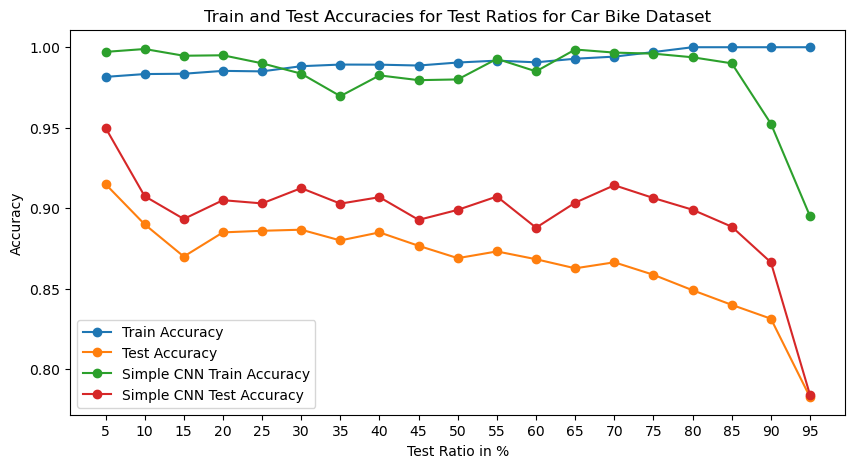

CIFAR10 Dataset


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[0.991578947368421, 0.9877777777777778, 0.991764705882353, 0.9925, 0.9906666666666667, 0.9942857142857143, 0.9923076923076923, 0.9933333333333333, 0.9945454545454545, 0.998, 0.9977777777777778, 1.0, 0.9942857142857143, 0.9966666666666667, 0.996, 0.995, 1.0, 1.0, 1.0]
[0.88, 0.89, 0.8666666666666667, 0.86, 0.86, 0.8566666666666667, 0.8514285714285714, 0.8325, 0.8355555555555556, 0.838, 0.8218181818181818, 0.8433333333333334, 0.8369230769230769, 0.8514285714285714, 0.844, 0.83375, 0.808235294117647, 0.7833333333333333, 0.76]
[0.9642105263157895, 0.9311111111111111, 0.9576470588235294, 0.9875, 0.9786666666666667, 0.9628571428571429, 0.98, 0.96, 0.94, 0.976, 0.96, 0.93, 0.9714285714285714, 0.94, 0.88, 0.935, 0.94, 0.84, 0.9]
[0.74, 0.75, 0.8733333333333333, 0.85, 0.84, 0.8566666666666667, 0.8228571428571428, 0.83, 0.8466666666666667, 0.834, 0.8327272727272728, 0.81, 0.8507692307692307, 0.8371428571428572, 0.8066666

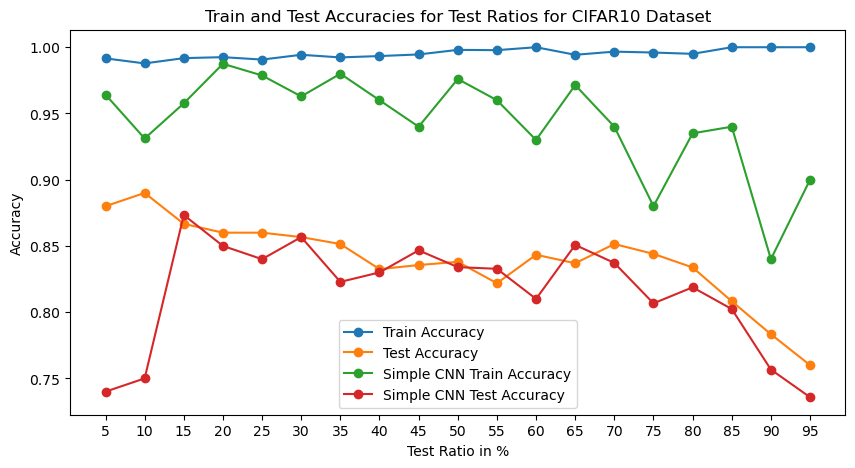

Pizza Dataset


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[0.9812533476164971, 0.9807801017524025, 0.9856373429084381, 0.9866412213740458, 0.9864314789687924, 0.9883720930232558, 0.9874706342991386, 0.993214588634436, 0.9944495837187789, 0.9918616480162767, 0.996606334841629, 0.9987277353689568, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.7474747474747475, 0.751269035532995, 0.7016949152542373, 0.7309644670050761, 0.7398373983739838, 0.7576271186440678, 0.7402031930333817, 0.7433290978398983, 0.7412429378531074, 0.7446592065106816, 0.7162661737523105, 0.7330508474576272, 0.7222222222222222, 0.6978939724037764, 0.7023728813559322, 0.7215511760966307, 0.7057416267942583, 0.6943502824858757, 0.6434689507494646]
[0.9025174076057847, 0.9327303561334087, 0.9413524835427888, 0.9083969465648855, 0.8934871099050203, 0.8771802325581395, 0.8465152701644479, 0.8473282442748091, 0.8482886216466234, 0.8850457782299085, 0.8800904977375565, 0.9274809160305344, 0.9084302325581395, 0.8726655

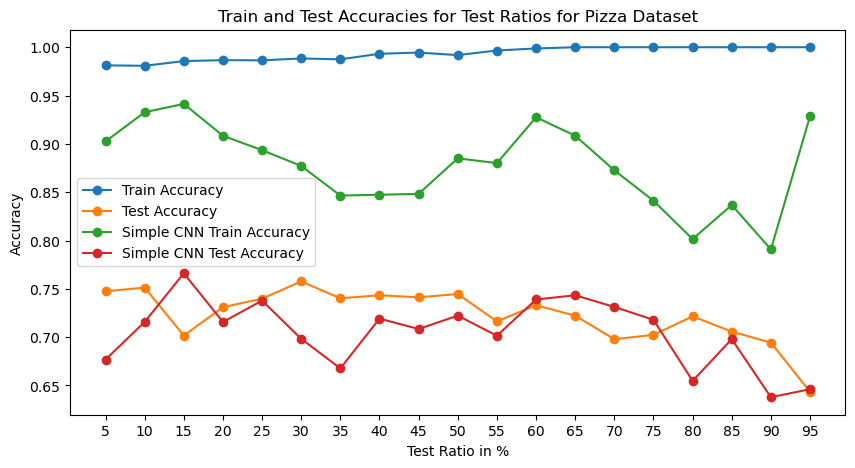

Corals Dataset


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[0.9828767123287672, 0.9843373493975903, 0.985969387755102, 0.989159891598916, 0.9855491329479769, 0.9907120743034056, 0.988313856427379, 0.9909584086799277, 0.9940828402366864, 0.9934924078091106, 0.9951807228915662, 0.994579945799458, 0.9969040247678018, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6382978723404256, 0.6451612903225806, 0.6330935251798561, 0.6162162162162163, 0.6277056277056277, 0.5956678700361011, 0.5833333333333334, 0.6081081081081081, 0.6033653846153846, 0.6103896103896104, 0.6043307086614174, 0.5992779783393501, 0.6266666666666667, 0.6321483771251932, 0.6378066378066378, 0.6305818673883626, 0.6394904458598726, 0.6486161251504212, 0.6305587229190421]
[0.9155251141552512, 0.9626506024096385, 0.8061224489795918, 0.9146341463414634, 0.9234104046242775, 0.9164086687306502, 0.8430717863105175, 0.918625678119349, 0.8520710059171598, 0.8026030368763557, 0.8554216867469879, 0.8373983739837398, 0.89473684210526

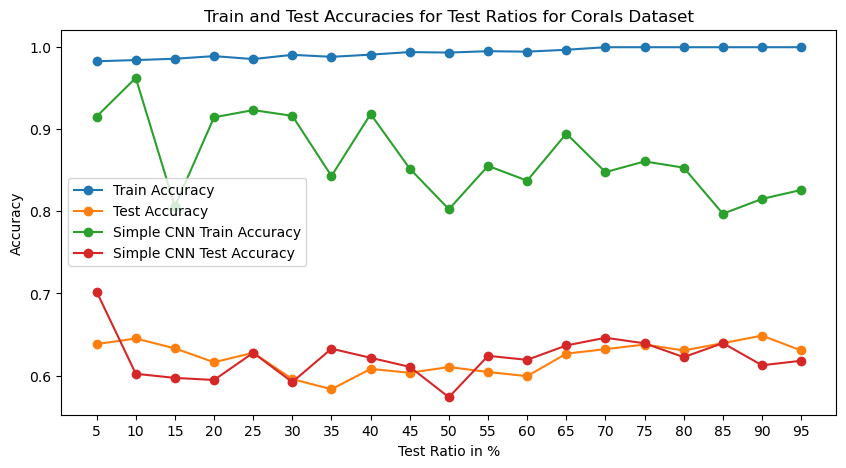

Eggs Dataset


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[0.9814323607427056, 0.9845938375350141, 0.9910979228486647, 0.9858267716535433, 0.9966386554621849, 0.990990990990991, 0.9903100775193798, 0.9936974789915967, 0.9908256880733946, 0.9949622166246851, 0.9971988795518207, 0.9968454258675079, 0.9963898916967509, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.75, 0.85, 0.8, 0.8238993710691824, 0.8190954773869347, 0.8158995815899581, 0.8057553956834532, 0.8207547169811321, 0.8156424581005587, 0.818639798488665, 0.8398169336384439, 0.8385744234800838, 0.8201160541586073, 0.8345323741007195, 0.8221476510067114, 0.8191823899371069, 0.8133333333333334, 0.7986013986013986, 0.7615894039735099]
[0.9270557029177718, 0.8921568627450981, 0.9169139465875371, 0.9039370078740158, 0.9126050420168067, 0.9027027027027027, 0.8817829457364341, 0.8886554621848739, 0.8807339449541285, 0.8942065491183879, 0.8739495798319328, 0.9022082018927445, 0.8700361010830325, 0.8823529411764706, 0.84343434343434

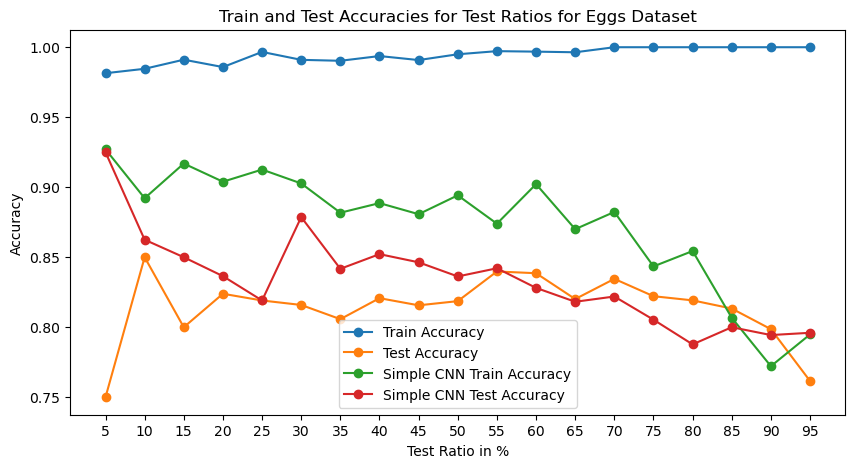

Xray Dataset


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[0.9886751752651447, 0.9878557874762809, 0.9869399236487844, 0.9888983774551665, 0.9890710382513661, 0.9899975603805806, 0.9894902785076195, 0.9903216623968119, 0.991304347826087, 0.9907786885245902, 0.9920303605313093, 0.9910333048676345, 0.9902391410444119, 0.9943052391799544, 0.9938524590163934, 0.9940222032450897, 0.9954441913439636, 0.9948717948717949, 1.0]
[0.9453924914675768, 0.9453924914675768, 0.944254835039818, 0.9377133105802048, 0.9426229508196722, 0.9413773477518498, 0.9434146341463414, 0.942381562099872, 0.9438543247344461, 0.9412568306010929, 0.9416330332194971, 0.9359704040978941, 0.9340688205936433, 0.9326829268292683, 0.9321493624772313, 0.9325506937033085, 0.9226597026918442, 0.9108328590400303, 0.9083393242271747]
[0.9920905985978788, 0.9870967741935484, 0.9704641350210971, 0.9869769427839453, 0.9735883424408015, 0.9826787021224689, 0.9829217025748818, 0.986336464560205, 0.9881987577639751, 

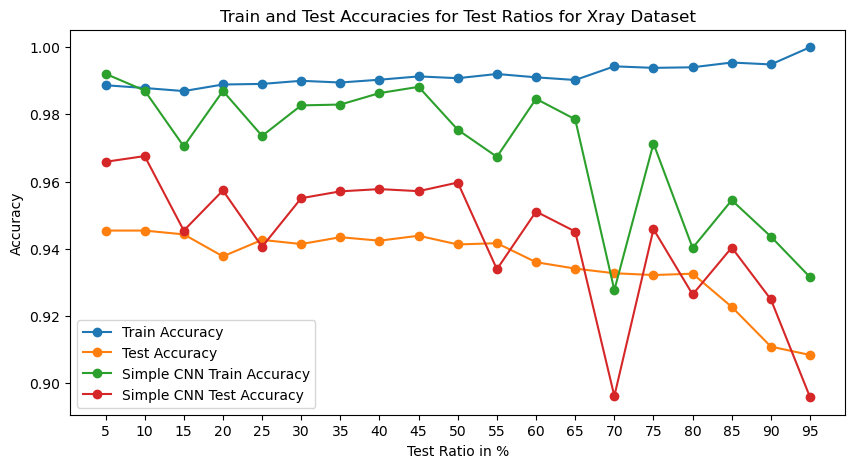

Covid19 Dataset


/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/parkmyungheon/anaconda3/envs/Keras/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 0.9824561403508771, 0.9855072463768116, 0.9875, 0.989010989010989, 1.0, 0.9912280701754386, 0.992, 0.9927007299270073, 0.9864864864864865, 0.9874213836477987, 0.9649122807017544, 0.989010989010989, 0.9430051813471503, 0.975609756097561, 0.9722222222222222]
[0.9953488372093023, 0.9950980392156863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9919354838709677, 0.9911504424778761, 0.9803921568627451, 0.9777777777777777, 0.9746835443037974, 0.9705882352941176, 0.9107142857142857, 1.0, 1.0, 0.9545454545454546, 1.0]
[1.0, 0.9565217391304348, 0.9714285714285714, 1.0, 0.9649122807017544, 0.9855072463768116, 0.975, 0.978021978021978, 0.9805825242718447, 0.9912280701754386, 0.976, 0.9708029197080292, 0.9797297297297297, 0.89937106918239, 0.9415204678362573, 0.9230769230769231, 0.917098445595855, 0.9073170731707317, 0.9

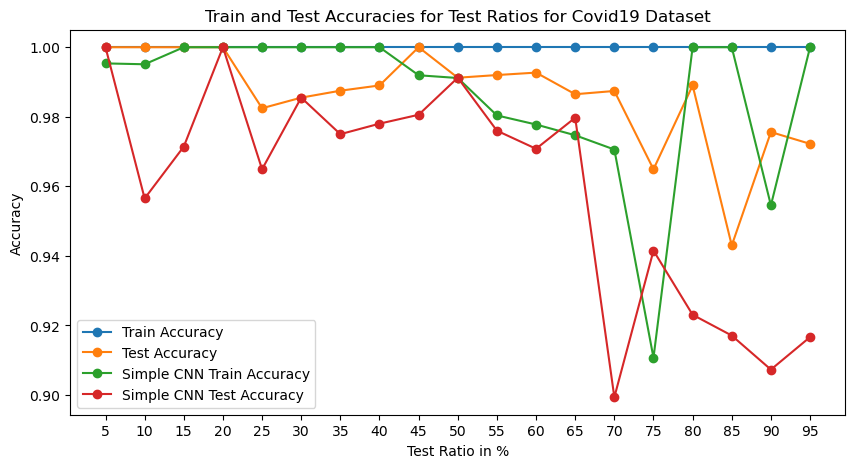

In [31]:
for dataset, name in datasets:
    print(name)
    test_different_split_ratio(dataset, name)